# Business Data Analytics Final Year Project  
Elevating Cinnamon Hotels & Resorts in Sri Lanka: Using Guest Reviews and Arrival Data

In [25]:
# Cell 2 – Imports & Setup
!pip install vaderSentiment -q

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

print("Libraries imported successfully.")

Libraries imported successfully.


# Cell 3 – Section 1: Data Loading & Initial Inspection

In [26]:
from google.colab import files
uploaded = files.upload()  # ← Upload 'Bad_Reviews_Dataset.xlsx'

df = pd.read_excel(list(uploaded.keys())[0])

print('Dataset shape (rows, columns):', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nFirst 3 rows preview:')
df.head(3)

Saving Bad_Reviews_Dataset.xlsx to Bad_Reviews_Dataset.xlsx
Dataset shape (rows, columns): (2880, 35)

Columns: ['ReviewDate', 'TravlerType', 'Platform', 'OwnerResponse', 'TotalReviewsbyUser', 'ValueforMoneyRating', 'FreeWifiRating', 'placeInfo/rating', 'ReviewTitle', 'CheckInDate', 'OverallRating', 'StaffRating', 'UserName', 'NumberofNights', 'CleanlinessRating', 'HotelRatingLabel', 'LocationRating', 'OwnerResponsepublishedDate', 'month_year', 'PropertyResponse', 'UserLocationinShort', 'RoomtipText', 'TripType', 'HotelRating', 'FacilitiesRating', 'ReviewLanguage', 'review_text', 'UserLocation', 'ComfortRating', 'DislikedText', 'RatingPublishedPlatform', 'SleepQualityRating', 'LikedText', 'CheckOutDate', 'Hotel/Resort']

First 3 rows preview:


,ReviewDate,TravlerType,Platform,OwnerResponse,TotalReviewsbyUser,ValueforMoneyRating,FreeWifiRating,placeInfo/rating,ReviewTitle,CheckInDate,...,ReviewLanguage,review_text,UserLocation,ComfortRating,DislikedText,RatingPublishedPlatform,SleepQualityRating,LikedText,CheckOutDate,Hotel/Resort
0,2025-11-06 10:55:18,Couple,Booking.com,NaN,NaN,4.0,4.1,NaN,Bad experience,2025-10-31,...,xu,No thing Different room provided reception ver...,Qatar,4.3,Different room provided reception very bad and...,NaN,NaN,No thing,2025-11-02,Cinnamon Citadel Kandy
1,2025-10-31 09:30:45,Couple,Booking.com,NaN,NaN,4.0,4.1,NaN,NaN,2025-10-15,...,xu,It’s big and beautiful in general \nHe has eve...,Chile,4.3,My room was with mosquitoes that didn’t let me...,NaN,NaN,It’s big and beautiful in general \nHe has eve...,2025-10-17,Cinnamon Citadel Kandy
2,2025-10-24 13:43:42,Family,Booking.com,NaN,NaN,4.0,4.1,NaN,NaN,2025-10-19,...,en,relaxed room setup with garden view and reclin...,Sri Lanka,4.3,the limited food options in the buffet for din...,NaN,NaN,relaxed room setup with garden view and reclin...,2025-10-20,Cinnamon Citadel Kandy


In [27]:
# Filter bad reviews and English only
df = df[df['OverallRating'] <= 3]
df = df[df['ReviewLanguage'].str.lower().str.contains('en|english', na=False)].reset_index(drop=True)
df['review_text'] = df['review_text'].fillna('')

# Final advanced cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def final_clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    cleaned = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 1]
    return ' '.join(cleaned)

df['cleaned_review'] = df['review_text'].apply(final_clean_text)
df['final_cleaned_review'] = df['cleaned_review'].copy()

# Remove empty cleaned rows
df = df[df['final_cleaned_review'].str.strip() != ''].reset_index(drop=True)

print('Filtered & fully cleaned shape:', df.shape)
print('\nSample text comparison (raw vs final cleaned):')
df[['review_text', 'final_cleaned_review']].head(4)

Filtered & fully cleaned shape: (1918, 37)

Sample text comparison (raw vs final cleaned):


,review_text,final_cleaned_review
0,relaxed room setup with garden view and reclin...,relaxed room setup garden view reclined chair ...
1,It’s decently large but the water retention on...,decently large water retention floor super ann...
2,"The property is huge, the buffet spread is ver...",property huge buffet spread nice location supe...
3,The staff were genuinely wonderful — from the ...,staff genuinely wonderful reception bar restau...


In [28]:
aspects_keywords = {
    'staff': ['staff', 'service', 'reception', 'manager', 'waiter', 'friendly', 'attitude', 'rude'],
    'room': ['room', 'bed', 'bathroom', 'view', 'balcony', 'clean', 'dirty', 'smell'],
    'food': ['food', 'buffet', 'restaurant', 'breakfast', 'dinner', 'meal', 'taste'],
    'location': ['location', 'beach', 'pool', 'area', 'city', 'close', 'far'],
    'value': ['price', 'value', 'money', 'expensive', 'worth', 'cost', 'cheap'],
    'facilities': ['wifi', 'gym', 'spa', 'facilities', 'amenities', 'bar', 'parking']
}

def categorize_aspects(text, keywords):
    aspects = []
    for aspect, kws in keywords.items():
        if any(re.search(r'\b' + re.escape(kw) + r'\b', text) for kw in kws):
            aspects.append(aspect)
    return aspects if aspects else ['other']

df['aspects'] = df['final_cleaned_review'].apply(lambda x: categorize_aspects(x, aspects_keywords))

print('Sample aspect categorization:')
df[['final_cleaned_review', 'aspects']].head(5)

Sample aspect categorization:


,final_cleaned_review,aspects
0,relaxed room setup garden view reclined chair ...,"[room, food]"
1,decently large water retention floor super ann...,[staff]
2,property huge buffet spread nice location supe...,"[staff, room, food, location]"
3,staff genuinely wonderful reception bar restau...,"[staff, room, food, location, facilities]"
4,location ambience good food best expected fly ...,"[room, food, location]"


In [29]:
analyzer = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['review_text'].apply(
    lambda x: analyzer.polarity_scores(x)['compound'] if x.strip() else 0
)

print('Sample sentiment scores (negative = bad):')
df[['review_text', 'sentiment_score']].head(6)

Sample sentiment scores (negative = bad):


,review_text,sentiment_score
0,relaxed room setup with garden view and reclin...,0.6908
1,It’s decently large but the water retention on...,0.7873
2,"The property is huge, the buffet spread is ver...",0.8748
3,The staff were genuinely wonderful — from the ...,0.9711
4,Location and the ambience were good. But the f...,-0.9041
5,"Room cleanness found a live cockroach, AC was ...",-0.5399


In [30]:
# ────────────────────────────────────────────────────────────────
# Section 5: Aggregation & Analysis (corrected with full cleaned reviews)
# ────────────────────────────────────────────────────────────────

df_exploded = df.explode('aspects')

agg_df = df_exploded.groupby(
    ['month_year', 'UserLocationinShort', 'Hotel/Resort', 'aspects']
).agg(
    count=('aspects', 'size'),
    avg_sentiment=('sentiment_score', 'mean'),
    # Full original raw reviews (joined)
    full_original_reviews=('review_text', lambda x: ' | '.join(x.str.strip().replace('\n', ' '))),
    # Full FINAL cleaned reviews (joined)
    final_cleaned_reviews=('final_cleaned_review', lambda x: ' | '.join(x.str.strip()))
).reset_index()

# Percentages
agg_df['total_reviews'] = agg_df.groupby(
    ['month_year', 'UserLocationinShort', 'Hotel/Resort']
)['count'].transform('sum')

agg_df['percentage'] = (agg_df['count'] / agg_df['total_reviews']) * 100

# Corrected sample excerpts (use 'in' check for lists)
def get_sample_excerpts(group, aspect):
    matching = group[group['aspects'].apply(lambda a: aspect in a)]['final_cleaned_review']
    if matching.empty:
        return 'No matching text'
    samples = matching.head(2).str[:180] + '...'
    return ' | '.join(samples)

agg_df['sample_excerpts'] = agg_df.apply(
    lambda r: get_sample_excerpts(
        df[(df['month_year'] == r['month_year']) &
           (df['UserLocationinShort'] == r['UserLocationinShort']) &
           (df['Hotel/Resort'] == r['Hotel/Resort'])],
        r['aspects']
    ), axis=1
)

# Sort
agg_df = agg_df.sort_values(['month_year', 'percentage'], ascending=[False, False])

print('Aggregated preview – now with final_cleaned_reviews column:')
agg_df.head(12)

Aggregated preview – now with final_cleaned_reviews column:


,month_year,UserLocationinShort,Hotel/Resort,aspects,count,avg_sentiment,full_original_reviews,final_cleaned_reviews,total_reviews,percentage,sample_excerpts
2841,2025-12,Tenterden,Cinnamon Lakeside Colombo,room,1,-0.4404,Living on a dated reputation. Not as prestine ...,living dated reputation prestine smashed door ...,1,100.000000,living dated reputation prestine smashed door ...
2835,2025-12,Colombo,Trinco Blu by Cinnamon,food,1,0.8591,"Overall, our stay was good. The room service a...",overall stay good room service facility satisf...,3,33.333333,overall stay good room service facility satisf...
2836,2025-12,Colombo,Trinco Blu by Cinnamon,room,1,0.8591,"Overall, our stay was good. The room service a...",overall stay good room service facility satisf...,3,33.333333,overall stay good room service facility satisf...
2837,2025-12,Colombo,Trinco Blu by Cinnamon,staff,1,0.8591,"Overall, our stay was good. The room service a...",overall stay good room service facility satisf...,3,33.333333,overall stay good room service facility satisf...
2838,2025-12,Singapore,Cinnamon Life Colombo,food,1,0.9944,Our check-in experience was unfortunately disa...,checkin experience unfortunately disappointing...,3,33.333333,checkin experience unfortunately disappointing...
2839,2025-12,Singapore,Cinnamon Life Colombo,room,1,0.9944,Our check-in experience was unfortunately disa...,checkin experience unfortunately disappointing...,3,33.333333,checkin experience unfortunately disappointing...
2840,2025-12,Singapore,Cinnamon Life Colombo,staff,1,0.9944,Our check-in experience was unfortunately disa...,checkin experience unfortunately disappointing...,3,33.333333,checkin experience unfortunately disappointing...
2801,2025-11,Beirut,Kandy Mist by Cinnamon,room,1,0.6249,Would be great if you could get rid of the wil...,would great could get rid wild reptile animal ...,1,100.000000,would great could get rid wild reptile animal ...
2804,2025-11,Colombo,Cinnamon Lakeside Colombo,staff,1,0.9420,The Indonesian tempered rice had a very good p...,indonesian tempered rice good portion brownie ...,1,100.000000,indonesian tempered rice good portion brownie ...
2805,2025-11,Dubai,Cinnamon Life Colombo,room,1,0.7648,I am presently staying here in Room 2114 to a...,presently staying room assess hype glass windo...,1,100.000000,presently staying room assess hype glass windo...


/tmp/ipython-input-2764490761.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_counts.values, y=aspect_counts.index, palette='viridis')


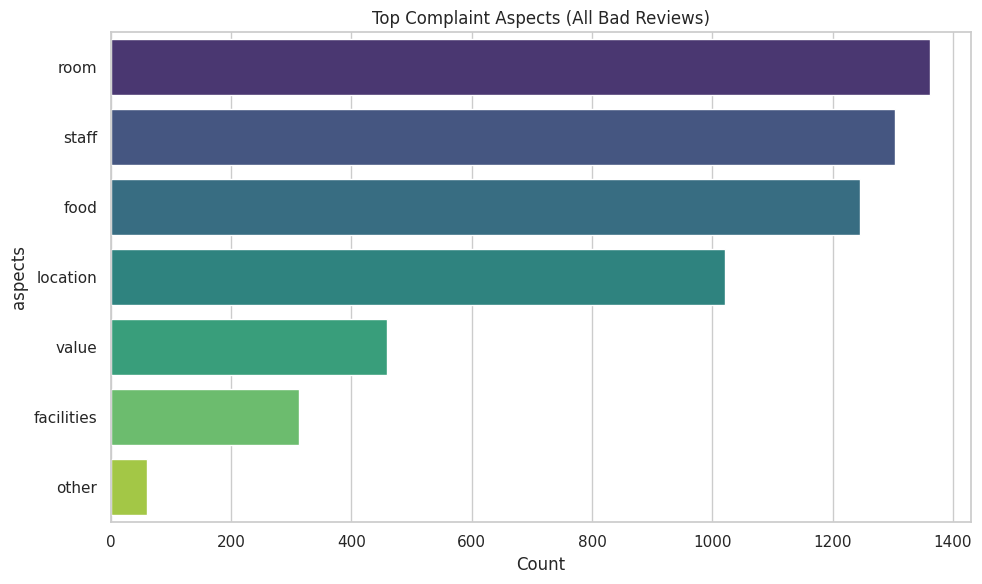

In [31]:
# Viz 1 – Top Aspects Bar
aspect_counts = df_exploded['aspects'].value_counts().head(8)
plt.figure(figsize=(10,6))
sns.barplot(x=aspect_counts.values, y=aspect_counts.index, palette='viridis')
plt.title('Top Complaint Aspects (All Bad Reviews)')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig('viz1_top_aspects.png', dpi=300, bbox_inches='tight')
plt.show()

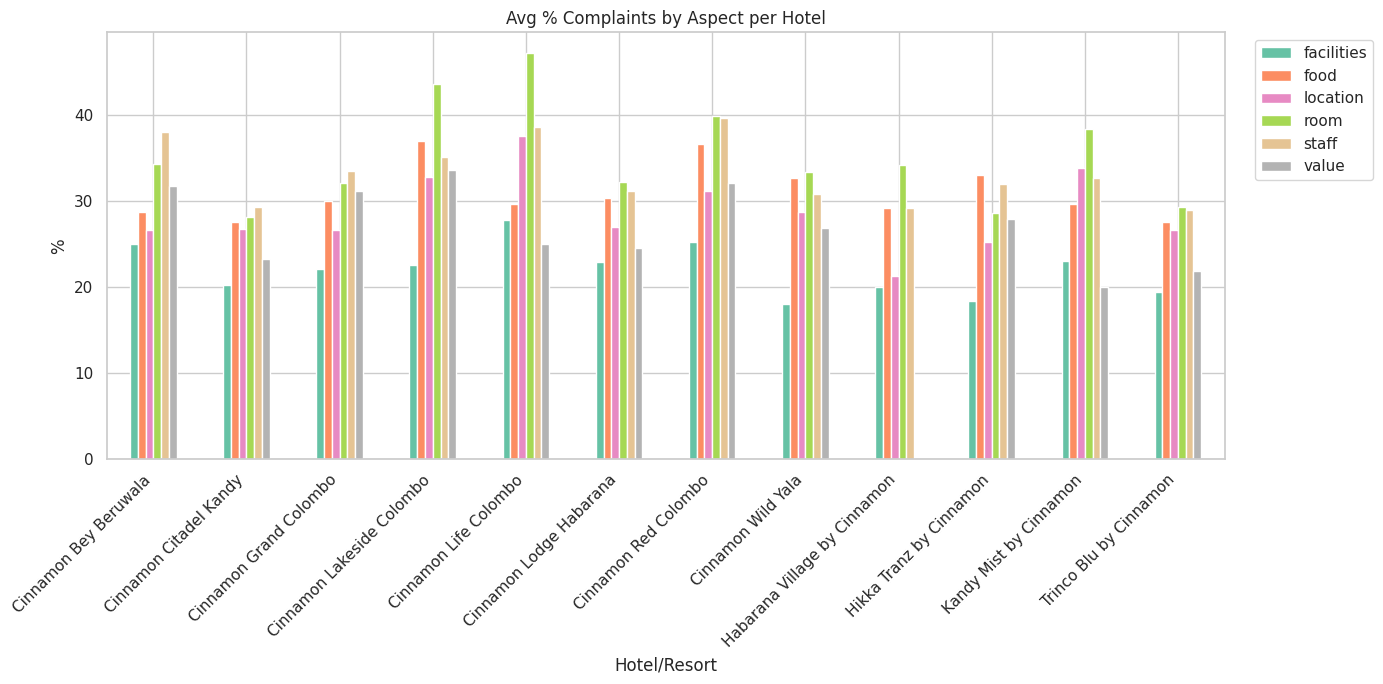

In [32]:
# Viz 2 – Aspects per Hotel
top_aspects = agg_df[agg_df['aspects'] != 'other'].groupby('aspects')['percentage'].mean().nlargest(6).index
hotel_aspect = agg_df[agg_df['aspects'].isin(top_aspects)].groupby(['Hotel/Resort','aspects'])['percentage'].mean().unstack()
hotel_aspect.plot(kind='bar', figsize=(14,7), colormap='Set2')
plt.title('Avg % Complaints by Aspect per Hotel')
plt.ylabel('%')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('viz2_per_hotel.png', dpi=300, bbox_inches='tight')
plt.show()

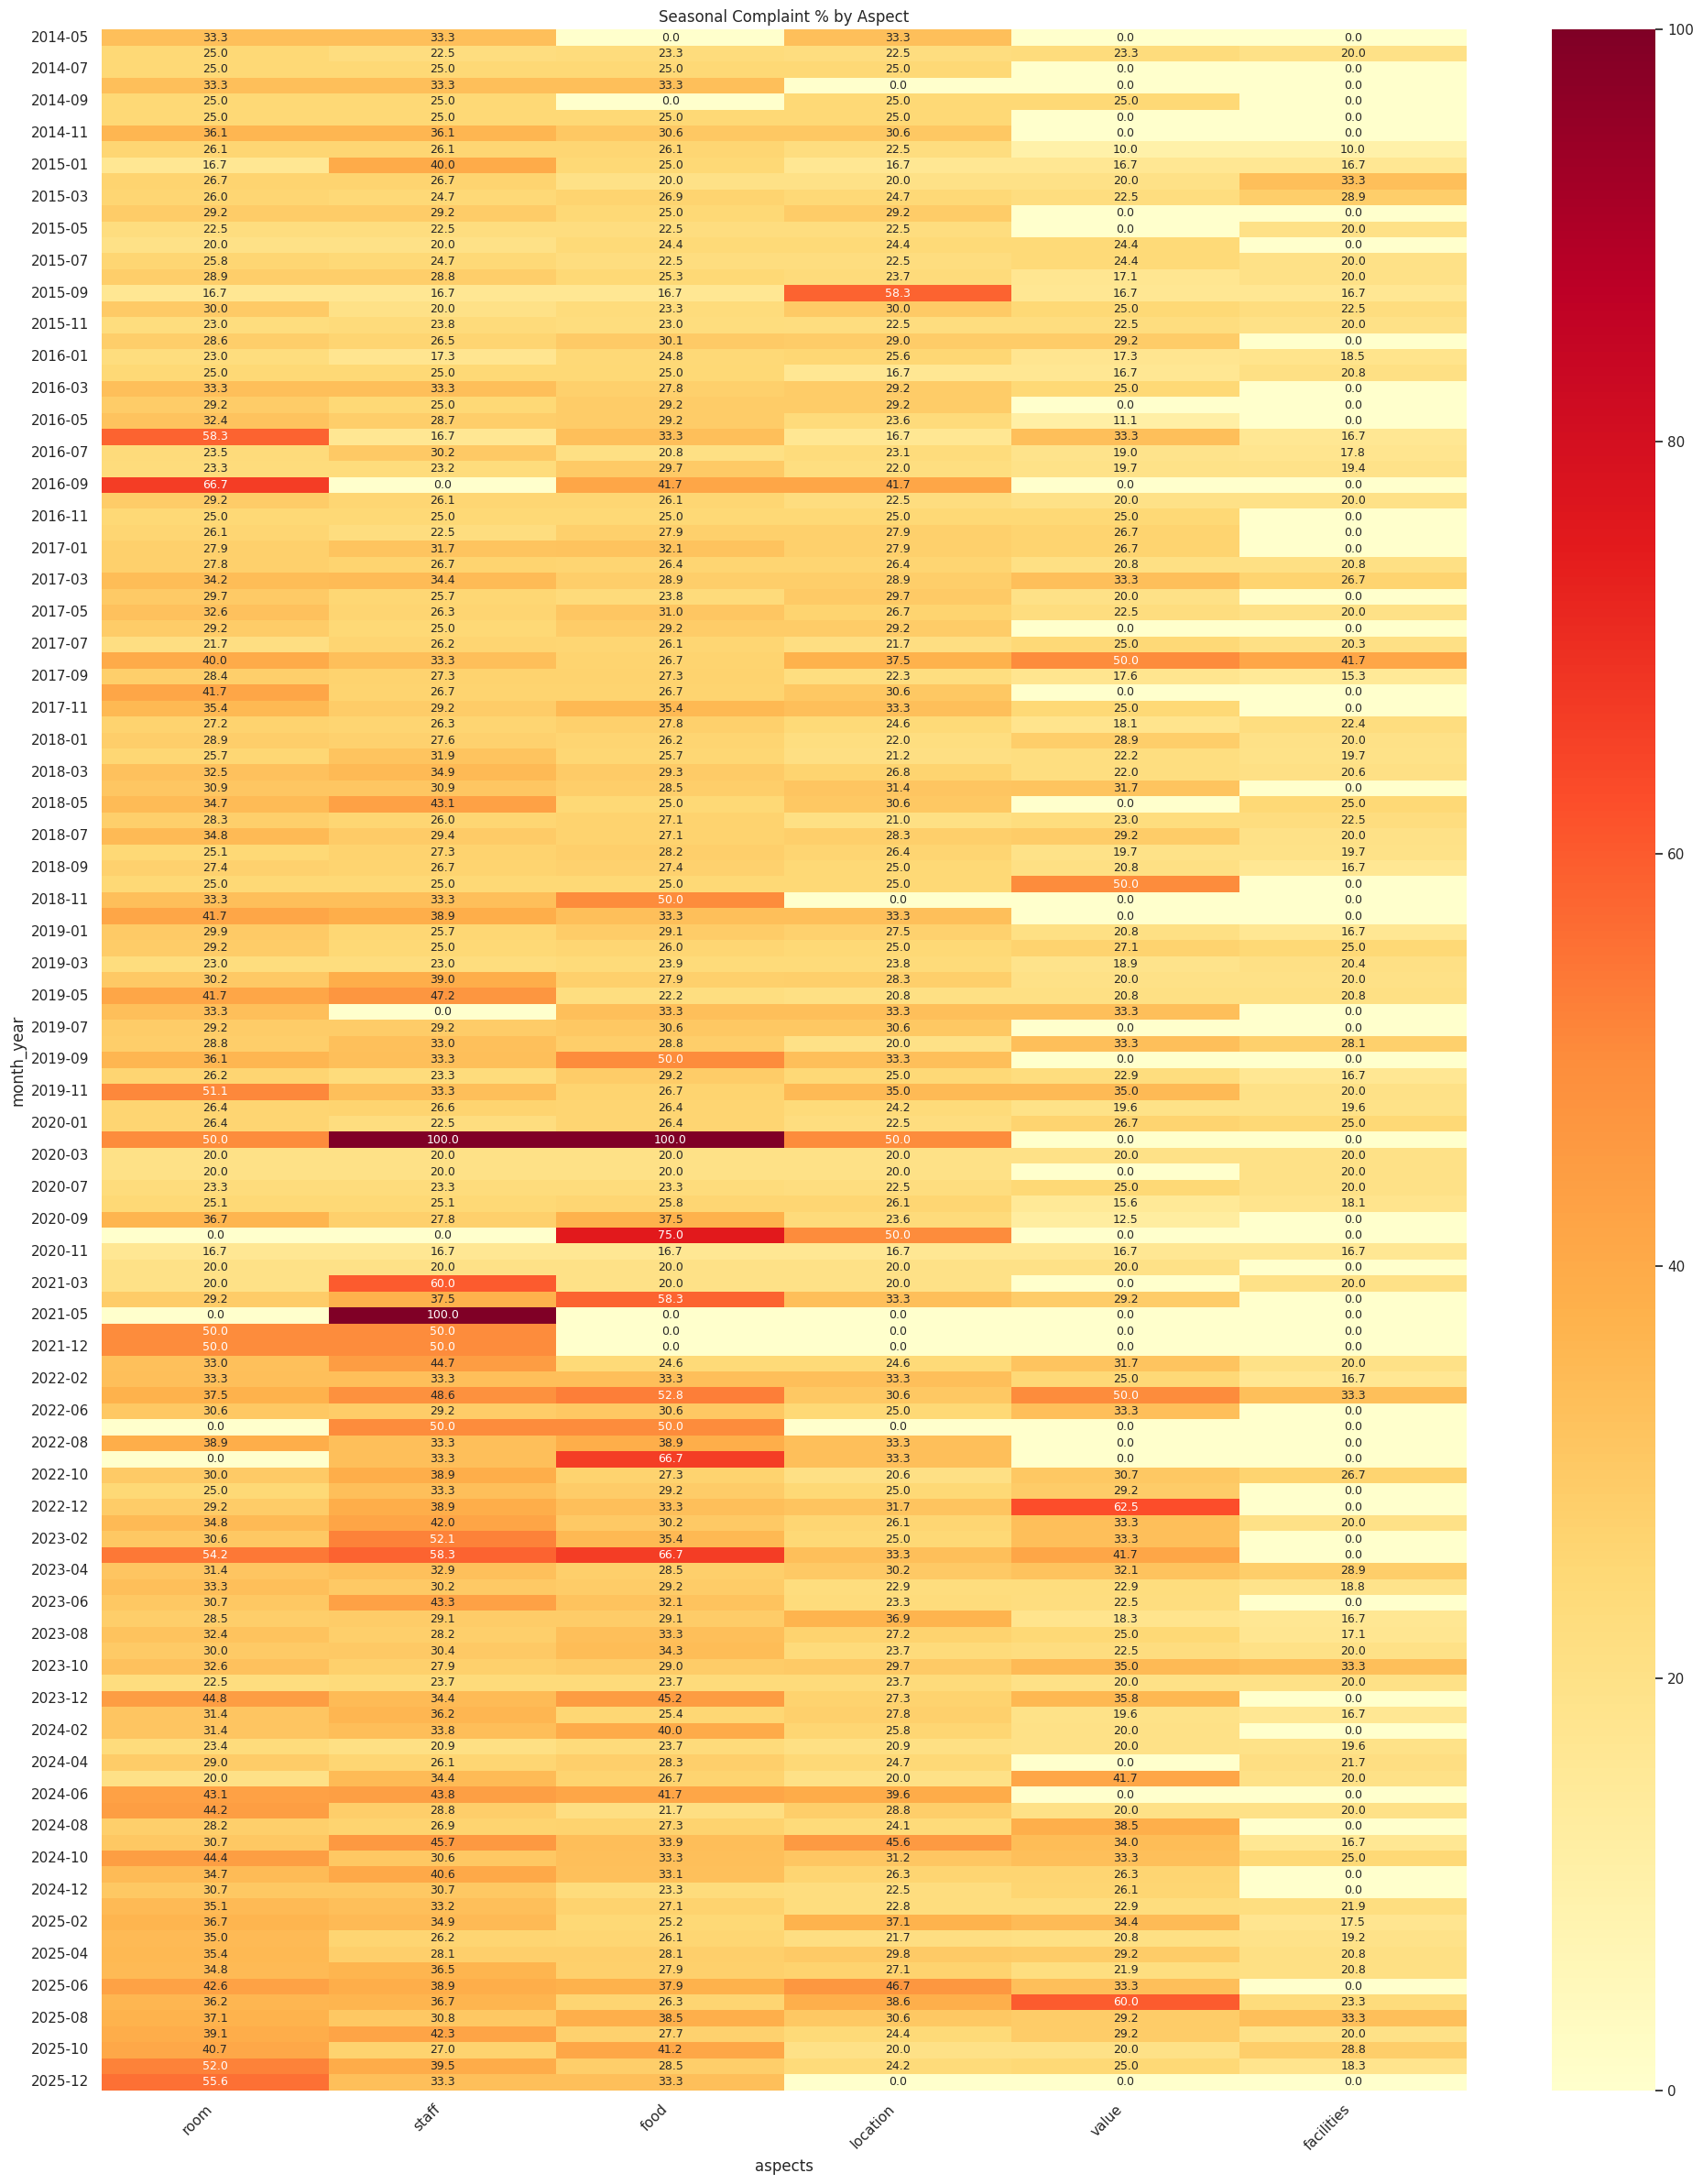

In [33]:
# Viz 3 – Heatmap (Month vs Aspect)
pivot = agg_df.pivot_table(index='month_year', columns='aspects', values='percentage', aggfunc='mean').fillna(0)
top_as = top_aspects
pivot = pivot[top_as]
plt.figure(figsize=(20, 24))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.1f', annot_kws={"size":9})
plt.title('Seasonal Complaint % by Aspect')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('viz3_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

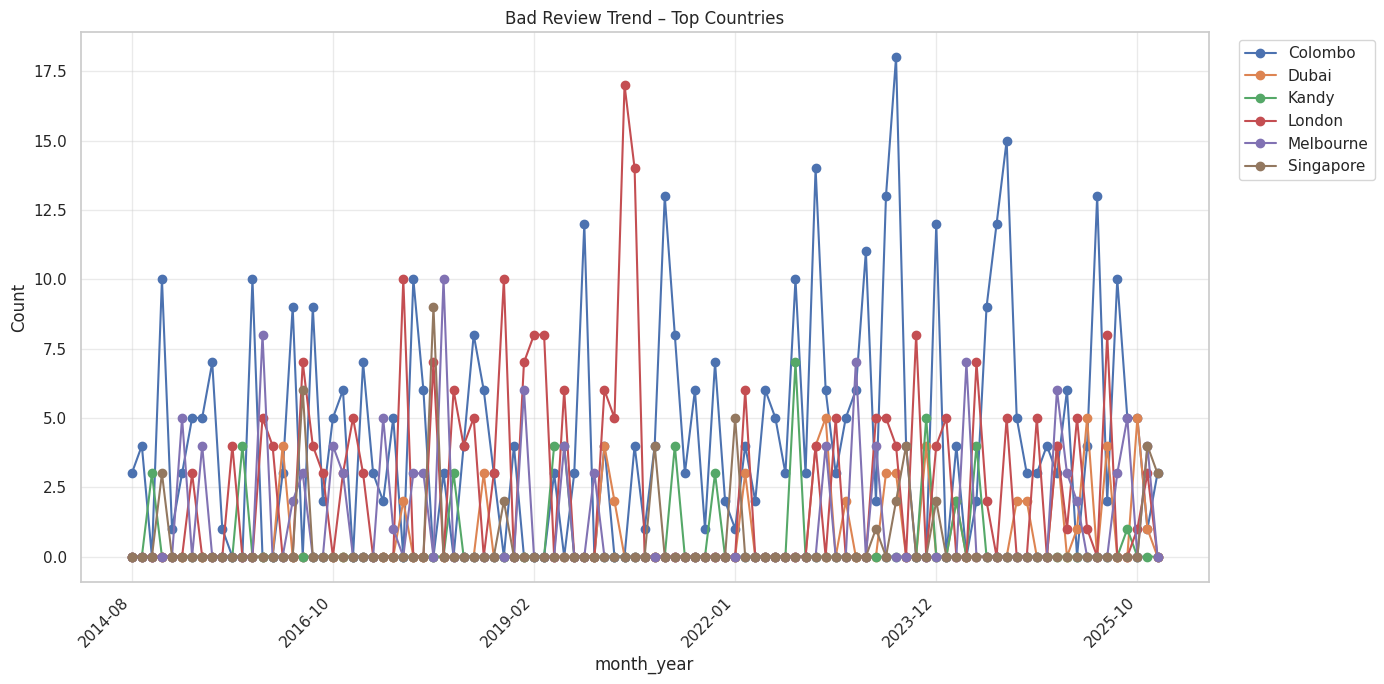

In [34]:
# Viz 4 – Trend by Top Countries
top_countries = agg_df['UserLocationinShort'].value_counts().head(6).index
country_trend = agg_df[agg_df['UserLocationinShort'].isin(top_countries)].groupby(['month_year','UserLocationinShort'])['count'].sum().unstack().fillna(0)
country_trend.plot(figsize=(14,7), marker='o')
plt.title('Bad Review Trend – Top Countries')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig('viz4_country_trend.png', dpi=300, bbox_inches='tight')
plt.show()

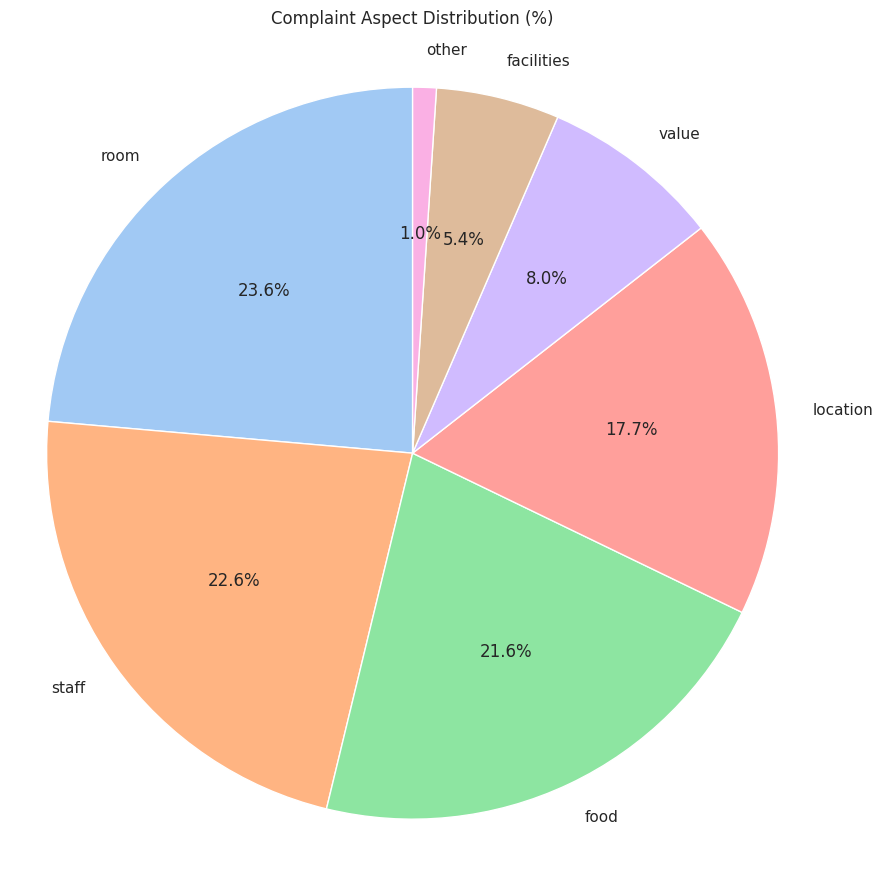

In [35]:
# Viz 5 – Pie Distribution
aspect_dist = df_exploded['aspects'].value_counts(normalize=True)*100
plt.figure(figsize=(9,9))
plt.pie(aspect_dist, labels=aspect_dist.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Complaint Aspect Distribution (%)')
plt.axis('equal')
plt.tight_layout()
plt.savefig('viz5_pie_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# Final exports – now includes cleaned text columns
df.to_csv('cinnamon_bad_reviews_full_processed.csv', index=False)
agg_df.to_csv('cinnamon_bad_reviews_aggregated_with_cleaned_text.csv', index=False)

print("\nExported files:")
print("1. cinnamon_bad_reviews_full_processed.csv          → full dataset with final_cleaned_review")
print("2. cinnamon_bad_reviews_aggregated_with_cleaned_text.csv → summary with full cleaned reviews joined")


Exported files:
1. cinnamon_bad_reviews_full_processed.csv          → full dataset with final_cleaned_review
2. cinnamon_bad_reviews_aggregated_with_cleaned_text.csv → summary with full cleaned reviews joined
